In [98]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

import sklearn
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import pydot

from ReliefF import ReliefF

### Get, prep, and explore data

https://medium.com/nerd-for-tech/data-engineering-a-feature-selection-example-with-the-iris-dataset-11f0554e4b00

https://towardsdatascience.com/feature-selection-choosing-the-right-features-for-your-machine-learning-algorithm-379bda9f3e05

In [64]:
# get iris
# Read in data and display first 5 rows
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

x = iris.data
y = iris.target

iris_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


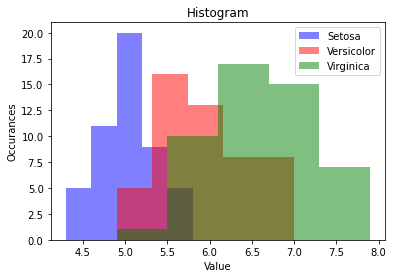

In [96]:
dim = 0  # the feature we want to compare

# each dataset is seperated into 5 intervals (by giving 5 to the bins variable)
plt.hist(iris.data[iris.target==0,dim], bins=5, histtype='stepfilled', color='b', alpha=0.5, label='Setosa')
plt.hist(iris.data[iris.target==1,dim], bins=5, histtype='stepfilled', color='r', alpha=0.5, label='Versicolor')
plt.hist(iris.data[iris.target==2,dim], bins=5, histtype='stepfilled', color='g', alpha=0.5, label='Virginica')

plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Occurances")
plt.legend()

In [9]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [13]:
scaler = MinMaxScaler()
scaler.fit(iris_df)

MinMaxScaler()

In [16]:
iris_norm=scaler.transform(iris_df)
iris_norm[:5]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667]])

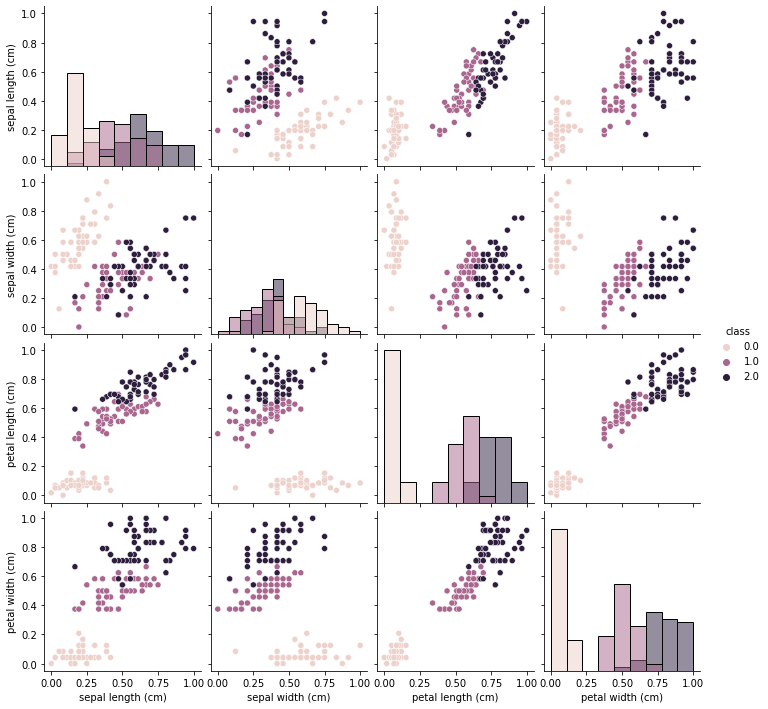

In [20]:
# visualizing features and target
iris_norm = pd.DataFrame(iris_norm, columns = iris_df.columns)
iris_norm_ = pd.DataFrame(np.hstack((iris_norm, y[:, np.newaxis])), columns = iris_df.columns.tolist() + ['class'])
sns.pairplot(iris_norm_, hue = 'class', diag_kind='hist')

<AxesSubplot:>

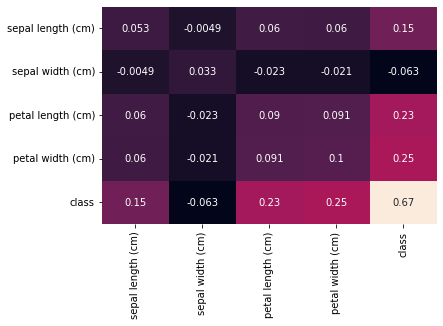

In [22]:
# manually verify the correlation among features and classes
iris_cov = iris_norm_.cov()
sns.heatmap(iris_cov, annot = True, cbar = False)

## ReliefF
https://medium.com/@yashdagli98/feature-selection-using-relief-algorithms-with-python-example-3c2006e18f83

Selects random sample and corresponding nearest neighbors of same and opposite classes. It helps find differences between the same values across different classes. ReliefF uses near-hit and near-miss.

In [113]:
fs = ReliefF(n_neighbors=12, n_features_to_keep=2)
X_train = fs.fit_transform(x, y)
print("(No. of tuples, No. of Columns before ReliefF) : "+str(iris.data.shape)+
      "\n(No. of tuples, No. of Columns after ReliefF) : "+str(X_train.shape))

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 0)

(No. of tuples, No. of Columns before ReliefF) : (150, 4)
(No. of tuples, No. of Columns after ReliefF) : (150, 2)


In [114]:
fs.feature_scores

array([-1108., -1070., -1046.,  -630.])

In [115]:
fs.n_features_to_keep

2

In [116]:
fs.top_features

array([3, 2, 1, 0], dtype=int64)

<AxesSubplot:ylabel='Count'>

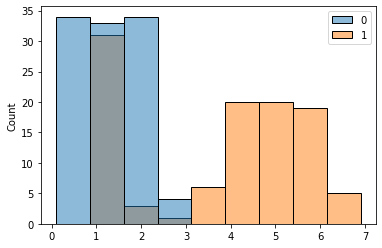

In [117]:
fs_t = fs.fit_transform(X_train,y_train)
sns.histplot(fs_t)

<AxesSubplot:ylabel='Count'>

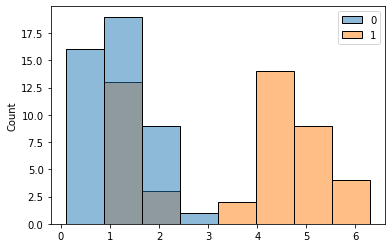

In [124]:
rel_mod = fs.fit_transform(X_test, y_test)
sns.histplot(rel_mod)

## Select K Best
https://medium.com/nerd-for-tech/data-engineering-a-feature-selection-example-with-the-iris-dataset-11f0554e4b00

Selects best features by the k highest score

In [90]:
bestfeatures = SelectKBest(score_func=f_classif, k=3)
iris_trim = bestfeatures.fit_transform(iris_norm, y)
print(bestfeatures.scores_)
print(bestfeatures.pvalues_)
print(iris_trim.shape)

iris_trim_df = pd.DataFrame(iris_trim,columns=bestfeatures.get_feature_names_out() )
iris_trim_df

[ 119.26450218   49.16004009 1180.16118225  960.0071468 ]
[1.66966919e-31 4.49201713e-17 2.85677661e-91 4.16944584e-85]
(150, 3)


,sepal length (cm),petal length (cm),petal width (cm)
0,0.222222,0.067797,0.041667
1,0.166667,0.067797,0.041667
2,0.111111,0.050847,0.041667
3,0.083333,0.084746,0.041667
4,0.194444,0.067797,0.041667
...,...,...,...
145,0.666667,0.711864,0.916667
146,0.555556,0.677966,0.750000
147,0.611111,0.711864,0.791667
148,0.527778,0.745763,0.916667


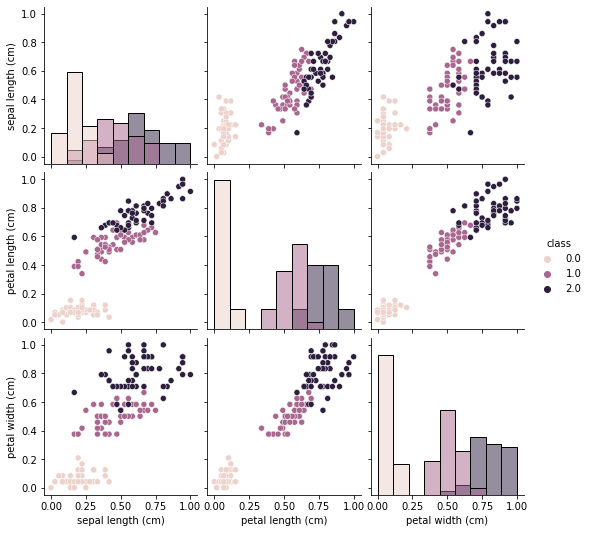

In [92]:
iris_trim_df = pd.DataFrame(iris_trim_df, columns = iris_trim_df.columns)
iris_trim_df_ = pd.DataFrame(np.hstack((iris_trim_df, y[:, np.newaxis])), 
                             columns = iris_trim_df.columns.tolist() + ['class'])

sns.pairplot(iris_trim_df_, hue = 'class', diag_kind='hist')

### Validation

In [93]:
def train_and_validate(X_train, X_test, y_train, y_test):
    mode = GaussianNB()    
    mode.fit(X_train, y_train);
    y_calc = mode.predict(X_test)
    y_prob = mode.predict_proba(X_test)
    #print(y_prob)
    mat = confusion_matrix(y_test, y_calc)
    sns.heatmap(mat.T, annot=True, cbar = False)

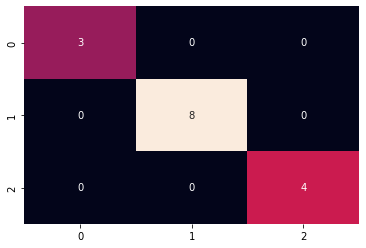

In [94]:
X_train4, X_test4, y_train, y_test = train_test_split(iris_norm, y, test_size = 0.10, stratify = None, random_state=0)
X_train3, X_test3 = X_train4.drop(['sepal width (cm)'], axis=1), X_test4.drop(['sepal width (cm)'], axis=1)

train_and_validate(X_train3, X_test3, y_train, y_test)

As you can see the second feature has the least score and the largest p-value. And the resulting dataset is of shape 150 x 3, the second feature (sepal width) was removed

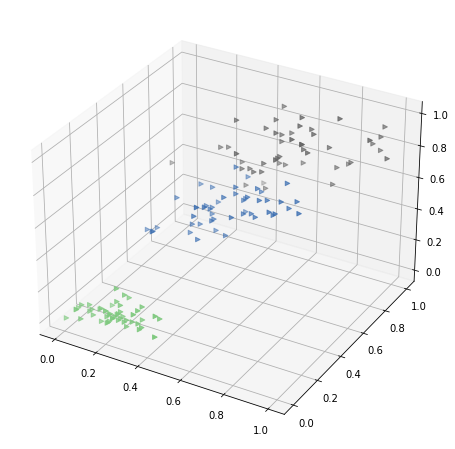

In [95]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(iris_trim[:, 0], iris_trim[:, 1], iris_trim[:, 2], 
             c = y, cmap='Accent', marker = '>')

## Exhaustive Feature Selector (EFS)

https://www.kaggle.com/code/ar2017/basics-of-feature-selection-with-python

Finds best subset of features by looking at all possible feature combinations

In [100]:
# Create a logistic regression classifier
lr = LogisticRegression()

# Create an EFS object
efs = EFS(estimator=lr,        # Use logistic regression as the classifier/estimator
          min_features=1,      # The minimum number of features to consider is 1
          max_features=4,      # The maximum number of features to consider is 4
          scoring='accuracy',  # The metric to use to evaluate the classifier is accuracy 
          cv=5)                # The number of cross-validations to perform is 5

# Train EFS with our dataset
efs = efs.fit(x, y)

# Print the results
print('Best accuracy score: %.2f' % efs.best_score_) # best_score_ shows the best score 
print('Best subset (indices):', efs.best_idx_)       # best_idx_ shows the index of features that yield the best score 
print('Best subset (corresponding names):', efs.best_feature_names_) # best_feature_names_ shows the feature names 

c:\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Features: 15/15

Best accuracy score: 0.97
Best subset (indices): (0, 1, 2, 3)
Best subset (corresponding names): ('0', '1', '2', '3')


In [103]:
# Transform the dataset
X_data_new = efs.transform(x)

# Print the results
print('Number of features before transformation: {}'.format(x.shape[1]))
print('Number of features after transformation: {}'.format(X_data_new.shape[1]))

Number of features before transformation: 4
Number of features after transformation: 4


In [104]:
efs_results = pd.DataFrame.from_dict(efs.get_metric_dict()).T
efs_results.sort_values(by='avg_score', ascending=True, inplace=True)
efs_results

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1,)","[0.5333333333333333, 0.5666666666666667, 0.533...",0.566667,"(1,)",0.046932,0.036515,0.018257
0,"(0,)","[0.6666666666666666, 0.7333333333333333, 0.766...",0.753333,"(0,)",0.069612,0.05416,0.02708
4,"(0, 1)","[0.7333333333333333, 0.8333333333333334, 0.766...",0.813333,"(0, 1)",0.069612,0.05416,0.02708
8,"(1, 3)","[0.9333333333333333, 0.9666666666666667, 0.9, ...",0.94,"(1, 3)",0.032061,0.024944,0.012472
11,"(0, 1, 3)","[0.9, 0.9666666666666667, 0.9333333333333333, ...",0.946667,"(0, 1, 3)",0.043691,0.033993,0.016997
2,"(2,)","[0.9333333333333333, 1.0, 0.9, 0.9333333333333...",0.953333,"(2,)",0.051412,0.04,0.02
5,"(0, 2)","[0.9333333333333333, 1.0, 0.9, 0.9333333333333...",0.953333,"(0, 2)",0.051412,0.04,0.02
6,"(0, 3)","[0.9333333333333333, 0.9666666666666667, 0.933...",0.953333,"(0, 3)",0.034274,0.026667,0.013333
7,"(1, 2)","[0.9333333333333333, 1.0, 0.9, 0.9333333333333...",0.953333,"(1, 2)",0.051412,0.04,0.02
10,"(0, 1, 2)","[0.9333333333333333, 1.0, 0.9, 0.9333333333333...",0.953333,"(0, 1, 2)",0.051412,0.04,0.02


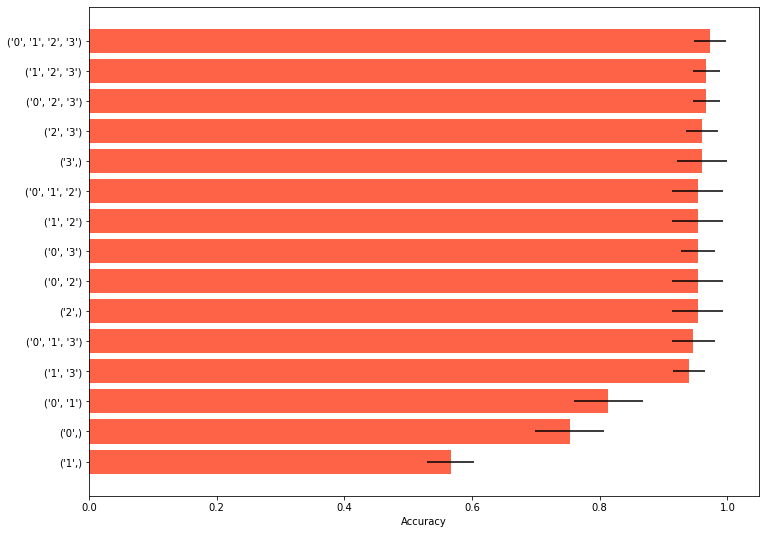

In [105]:
# Create a horizontal bar chart for visualizing 
# the performance of each subset of features
fig, ax = plt.subplots(figsize=(12,9))
y_pos = np.arange(len(efs_results))
ax.barh(y_pos, 
        efs_results['avg_score'],
        xerr=efs_results['std_dev'],
        color='tomato')
ax.set_yticks(y_pos)
ax.set_yticklabels(efs_results['feature_names'])
ax.set_xlabel('Accuracy')
plt.show()

## Final analysis

ReliefF did a great job reducing a model to an extremely small feature set was wise. I felt most comfortable with EFS. It spoke to how I approach problem solving and applied ranks accordingly. Select K best was also great to use. It is something I want to pull this into my work!